## Bayesian Optimisation Verification

In [4]:
# import relevant packages
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel

from math import sin
from math import pi
from numpy import arange
from numpy import vstack
from numpy import argmax
from numpy import asarray
from numpy.random import normal
from numpy.random import random
from scipy.stats import norm
from warnings import catch_warnings
from warnings import simplefilter

# stop showing warning messages
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [2]:
# Setup data for training and evaluation
X_ = np.linspace(0,5000, 5000)
# import timestamp from data sheet (time:0~5000s) 
address = 'data/degradation.xlsx'
df_time = X_
# import data sheet at 85 C (time:0~5000s) 
df = pd.read_excel(address,sheet_name = 'normal data',usecols = [3],names = None,nrows = 5000)
df_85 = df.values.tolist() 
df = pd.read_excel(address,sheet_name = 'smooth data',usecols = [3],names = None,nrows = 5000)
df_85s = df.values.tolist()
# Format date into numpy array format
y_normal = np.array(df_85).T 
y_normal = y_normal.reshape((5000))
x_normal = X_
x_7_5000 = np.array([0,99,999,1999,2999,3999,4999])

In [60]:
# objective function
def objective(X):
	return y_normal[X]

# surrogate or approximation for the objective function
def surrogate(model, X):
	# catch any warning generated when making a prediction
	with catch_warnings():
		# ignore generated warnings
		simplefilter("ignore")
		return model.predict(X, return_std=True)

# probability of improvement acquisition function
def acquisition(X, Xsamples, model):
	# calculate the best surrogate score found so far
	yhat, _ = surrogate(model, X)
	best = max(yhat)
	# calculate mean and stdev via surrogate function
	mu, std = surrogate(model, Xsamples)
	mu = mu[:, 0]
	# calculate the probability of improvement
	probs = norm.cdf((mu - best) / (std+1E-9))
	return probs

# optimize the acquisition function
def opt_acquisition(X, y, model):
	# random search, generate random samples
	Xsamples = random(5000)
	Xsamples = Xsamples.reshape(len(Xsamples), 1)
	# calculate the acquisition function for each sample
	scores = acquisition(X, Xsamples, model)
	# locate the index of the largest scores
	ix = argmax(scores)
	return ix

# plot real observations vs surrogate function
def plot (X, X_, y_normal, model):
	y, _ = surrogate(model, X)
	#plot function
	plt.figure()
	plt.scatter(X_, y_normal, c='grey', s=1, zorder=1)
	plt.scatter(X, y_normal[X], c='green', s=5, zorder=4)
	plt.plot(X, y, c='red', lw=2, zorder=3)
	plt.tick_params(axis='y', colors = 'white')
	plt.tick_params(axis='x', colors = 'white')
	plt.ylabel('Lifetime',color = 'white')
	plt.xlabel('Time',color = 'white')
	plt.title('Plot',color = 'white')
	plt.tight_layout()
	plt.show()

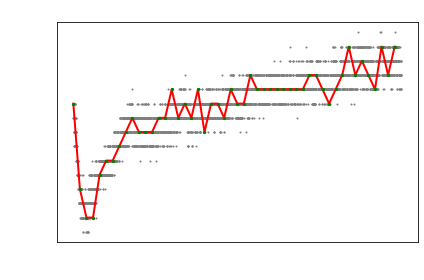

>x=1210.000, f()=0.000000, actual=0.743
>x=3442.000, f()=0.000000, actual=0.748
>x=1143.000, f()=0.000000, actual=0.745
>x=962.000, f()=0.000000, actual=0.744
>x=2172.000, f()=0.000000, actual=0.746
>x=4831.000, f()=0.000000, actual=0.749
>x=3990.000, f()=0.000000, actual=0.748
>x=3394.000, f()=0.000000, actual=0.749
>x=873.000, f()=0.000000, actual=0.746
>x=1409.000, f()=0.000000, actual=0.745
>x=119.000, f()=0.000000, actual=0.739
>x=4435.000, f()=0.000000, actual=0.748
>x=917.000, f()=0.000000, actual=0.745
>x=1401.000, f()=0.451392, actual=0.746
>x=4412.000, f()=0.000000, actual=0.747
>x=1954.000, f()=0.000000, actual=0.746
>x=3767.000, f()=0.000000, actual=0.748
>x=3059.000, f()=0.000000, actual=0.747
>x=25.000, f()=0.000000, actual=0.744
>x=2020.000, f()=0.000000, actual=0.746
>x=4647.000, f()=0.000000, actual=0.749
>x=1147.000, f()=0.000250, actual=0.744
>x=853.000, f()=0.000000, actual=0.745
>x=785.000, f()=0.000000, actual=0.743
>x=2687.000, f()=0.000000, actual=0.746
>x=1073.

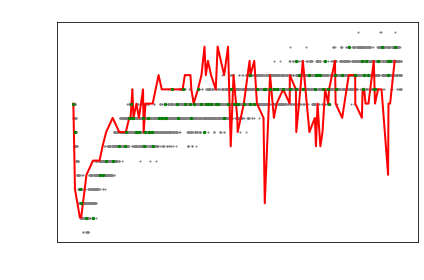

Best Result: x=2000.000, y=0.750


In [61]:
# sample the domain sparsely
NUM_OF_DATA_POINTS = 50
X = np.arange(0,5000,int(5000/NUM_OF_DATA_POINTS))
y =  y_normal[X]
# reshape into rows and cols
X = X.reshape(len(X), 1)
y = y.reshape(len(y), 1)
# define the model
model = GaussianProcessRegressor()
# fit the model
model.fit(X, y)
# plot before hand
plot (X, X_, y_normal, model)
# perform the optimization process
for i in range(50):
	# select the next point to sample
	x = opt_acquisition(X, y, model)
	# sample the point
	actual = objective(x)
	# summarize the finding
	est, _ = surrogate(model, [[x]])
	print('>x=%.3f, f()=%3f, actual=%.3f' % (x, est, actual))
	# add the data to the dataset
	# X = vstack((X, [[x]]))
	# y = vstack((y, [[actual]]))
	X = np.append(X, x)
	X = np.sort(X)
	y = np.append(y, y_normal[x])
	X = X.reshape(len(X), 1)
	y = y.reshape(len(y), 1)
	# update the model
	model.fit(X, y)

X = np.sort(X)

# plot all samples and the final surrogate function
plot (X, X_, y_normal, model)
# best result
ix = argmax(y)
print('Best Result: x=%.3f, y=%.3f' % (X[ix], y[ix]))